In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.3.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pickle
import csv
from scipy.stats import chisquare, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from geopy.distance import distance
import os
import ast
from hyperopt import STATUS_OK
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import hp
import hyperopt
from timeit import default_timer as timer

In [4]:
# define root mean square error
def rmse(act, pre): return(np.sqrt(np.mean(np.square(act-pre))))

In [5]:
# Calculate number of stations within key distance from building
def calc_dis(p, key = 1):
    dis = np.array([distance(p,x).miles for x in sub_cord])
    best_stations = sum(dis<key) 
    return(best_stations)

In [6]:
# Create variable to demarkate how far is a block from central park
def map_dis(val):
    if val in one_block_away:
        dis = 'one_block_away'
    elif val in two_block_away:
        dis = 'two_block_away'
    else:
        dis = 'three_block_away'
    return(dis)

In [7]:
# Hyperopt optimization
def objective(params):
    global ITERATION
    ITERATION +=1
    model = XGBRegressor(learning_rate = 0.05, max_depth = params['depth'], 
                         min_child_weight = params['min_child_weight'], gamma = params['gamma'], 
                         subsample = params['subsample'], colsample_bytree=params['colsample_bytree'], 
                         eval_metric='rmse', seed = 24, n_jobs = -1)
    start = timer()
    srtc = []
    xgtrain = xgb.DMatrix(X_ps_train_enc, label=y_ps_train)
    xgval = xgb.DMatrix(X_ps_test_enc, label = y_ps_test)
    xgb_params = model.get_xgb_params()
    watchlist = [(xgtrain, 'train'), (xgval, 'val')]
    xgbresults = xgb.train(xgb_params, xgtrain, num_boost_round = 5000, evals = watchlist, 
                           early_stopping_rounds = 100, verbose_eval = False)
    n_tree = xgbresults.best_ntree_limit
    #print('n_tree: {}'.format(n_tree))
    srtc.append(rmse(xgbresults.predict(xgb.DMatrix(X_ps_test_enc)), y_ps_test))
    train_time = timer()-start
    loss = np.mean(srtc)
    if ITERATION%50 == 0: 
        print('ITERATION: %d' %(ITERATION))
        print('params: ', params)
        print('loss: %.5f' %(loss))
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([ITERATION, loss, params, train_time, n_tree])
    return {'iteration': ITERATION, 'loss': loss, 'params': params,   
            'train_time': train_time, 'n_trees': n_tree, 'status': STATUS_OK}

In [8]:
# import PID data
data = pd.read_csv(r'F:\Old_Desktop\UC Davis\NYC permit data\DOB_Permit_Issuance.csv')

F:\Python\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (8,9,15,31,33,34,35,36,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
print(data.shape)
data.head()

(2370415, 60)


,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,...,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,PERMIT_SI_NO,LATITUDE,LONGITUDE,COUNCIL_DISTRICT,CENSUS_TRACT,NTA_NAME
0,BRONX,2102476.0,200,E 135TH STREET,240249842.0,1.0,A2,Y,2319,120,...,PA,19355,6.10401e+09,03/27/2019 12:00:00 AM,3608996.0,40.810699,-73.931313,8.0,51.0,Mott Haven-Port Morris
1,MANHATTAN,1090833.0,249,WEST 14 STREET,140818435.0,1.0,A3,Y,764,10,...,NY,11101,7.18392e+09,03/27/2019 12:00:00 AM,3609359.0,40.739151,-74.001075,3.0,81.0,Hudson Yards-Chelsea-Flatiron-Union Square
2,MANHATTAN,1015903.0,20,WEST 36TH STREET,123372466.0,2.0,A2,Y,837,58,...,NY,10021,2.12249e+09,03/27/2019 12:00:00 AM,3609159.0,40.750090,-73.984513,4.0,84.0,Midtown-Midtown South
3,QUEENS,4467709.0,14-30,BROADWAY,421105618.0,1.0,A2,Y,529,2,...,NY,11101,7.18473e+09,03/27/2019 12:00:00 AM,3609358.0,40.765826,-73.932800,22.0,45.0,Astoria
4,QUEENS,4048873.0,42-06,108 STREET,421024689.0,1.0,A1,N,1986,37,...,NY,11368,7.18279e+09,03/27/2019 12:00:00 AM,3606599.0,40.749221,-73.858003,21.0,403.0,North Corona


In [10]:
data.columns

Index(['BOROUGH', 'Bin #', 'House #', 'Street Name', 'Job #', 'Job doc. #',
       'Job Type', 'Self_Cert', 'Block', 'Lot', 'Community Board', 'Zip Code',
       'Bldg Type', 'Residential', 'Special District 1', 'Special District 2',
       'Work Type', 'Permit Status', 'Filing Status', 'Permit Type',
       'Permit Sequence #', 'Permit Subtype', 'Oil Gas', 'Site Fill',
       'Filing Date', 'Issuance Date', 'Expiration Date', 'Job Start Date',
       'Permittee's First Name', 'Permittee's Last Name',
       'Permittee's Business Name', 'Permittee's Phone #',
       'Permittee's License Type', 'Permittee's License #',
       'Act as Superintendent', 'Permittee's Other Title', 'HIC License',
       'Site Safety Mgr's First Name', 'Site Safety Mgr's Last Name',
       'Site Safety Mgr Business Name', 'Superintendent First & Last Name',
       'Superintendent Business Name', 'Owner's Business Type', 'Non-Profit',
       'Owner's Business Name', 'Owner's First Name', 'Owner's Last Name',
 

In [11]:
data['BOROUGH'].unique()

array(['BRONX', 'MANHATTAN', 'QUEENS', 'BROOKLYN', 'STATEN ISLAND',
       '  "error" : true', '  "message" : "Internal error"',
       '  "status" : 500', '}'], dtype=object)

In [12]:
# Valid borough values
data = data.loc[data['BOROUGH'].isin(['BRONX', 'MANHATTAN', 'QUEENS', 'BROOKLYN', 'STATEN ISLAND']),:]

In [13]:
# Columns to be deleted
del_cols = ['Bin #', 'House #', 'Job #', 'Job doc. #', 'Special District 1', 'Special District 2', 'Oil Gas', 'Site Fill',
           "Permittee's First Name", "Permittee's Last Name", "Permittee's Business Name", "Permittee's Phone #",
           "Permittee's License #", 'Act as Superintendent', "Permittee's Other Title", 'HIC License', 
            "Site Safety Mgr's First Name", "Site Safety Mgr's Last Name", 'Site Safety Mgr Business Name', 
            'Superintendent First & Last Name', 'Superintendent Business Name', "Owner's Business Name", "Owner's First Name", 
            "Owner's Last Name", "Owner's House #", "Owner's House Street Name", "Owner’s House State", "Owner’s House Zip Code", 
            "Owner's Phone #", "Owner’s House City", 'PERMIT_SI_NO']
data.drop(del_cols, inplace = True, axis = 1)

In [15]:
cat_cols = ['BOROUGH', 'Job Type', 'Bldg Type', 'Work Type', 'Permit Status', 'Filing Status',
            'Permit Type', 'Permit Subtype', "Permittee's License Type", 'Residential']
[print(k, data[k].unique()) for k in cat_cols]

BOROUGH ['BRONX' 'MANHATTAN' 'QUEENS' 'BROOKLYN' 'STATEN ISLAND']
Job Type ['A2' 'A3' 'A1' 'NB' 'DM' 'SG']
Bldg Type [ 2.  1. nan]
Work Type ['PL' 'EQ' 'MH' nan 'OT' 'SP' 'SD' 'FS' 'FP' 'BL' 'FB' 'CC' 'FA']
Permit Status ['ISSUED' 'RE-ISSUED' nan 'IN PROCESS' 'REVOKED']
Filing Status ['INITIAL' 'RENEWAL']
Permit Type ['PL' 'EQ' 'EW' 'AL' 'FO' 'NB' 'DM' 'SG']
Permit Subtype [nan 'OT' 'MH' 'EA' 'SP' 'CH' 'SH' 'FN' 'SD' 'FS' 'FP' 'BL' 'SF' 'FB' 'FA']
Permittee's License Type ['MP' 'GC' 'FS' 'NW' 'OB' 'OW' 'PE' 'SI' 'RA' nan 'DM' 'HI']
Residential [nan 'YES']


[None, None, None, None, None, None, None, None, None, None]

In [16]:
# mapping the values
data['Permit Type'] = data['Permit Type'].map({'EW': 'Equipment Work', 'PL': 'Plumbing',
                                            'EQ': 'Construction Equipment', 'AL': 'Alteration',
                                            'NB': 'New Building', 'FO': 'Foundation',
                                            'SG': 'Sign', 'DM': 'Demolition'})

In [17]:
# Converting datetime columns to datetime format
date_cols = ['Filing Date', 'Issuance Date', 'Expiration Date']
data[date_cols] = data[date_cols].apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y %I:%M:%S %p'))

In [18]:
# save the dataframe
with open(r'F:\Old_Desktop\UC Davis\NYC permit data\data.pkl', 'wb') as file:
    pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# with open(r'F:\Old_Desktop\UC Davis\NYC permit data\data.pkl', 'rb') as file:
#     data = pickle.load(file)

#### Is the variation in number of permits for residential buildings across the boroughs statistically significant?

In [20]:
# data with Residential building
data_resid = data.query("Residential == 'YES'")

In [21]:
data_resid.shape

(1111522, 29)

In [22]:
resid_borough = data_resid.groupby('BOROUGH').size()
tot_borough = data.groupby('BOROUGH').size()

Text(0.5, 1.0, 'Rate of Residential permits w.r.t boroughs')

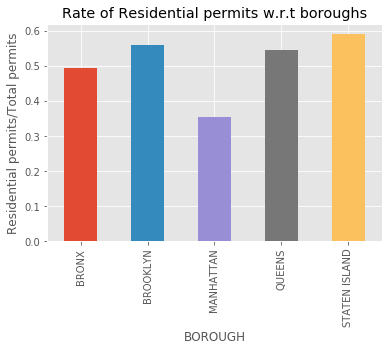

In [23]:
(resid_borough/tot_borough).plot(kind = 'bar')
plt.ylabel('Residential permits/Total permits')
plt.title('Rate of Residential permits w.r.t boroughs')

In [24]:
resid_borough.sum()/tot_borough.sum()

0.46891530624857886

In [25]:
chisquare(resid_borough.values, 0.468*tot_borough.values)

Power_divergenceResult(statistic=48297.07436704736, pvalue=0.0)

#### Does NYC prefer permits for a particular job type over the other depending on the borough?

In [26]:
tot_borough_jtype = pd.crosstab(data['BOROUGH'], data['Job Type'])

In [27]:
tot_borough_jtype

Job Type,A1,A2,A3,DM,NB,SG
BOROUGH,,,,,,
BRONX,14000,100561,28115,4865,39847,4680
BROOKLYN,79550,299728,69133,18861,107971,8744
MANHATTAN,45666,748027,131240,6718,22593,17983
QUEENS,85367,229350,45328,21102,114921,9659
STATEN ISLAND,14009,43307,7038,6802,42452,2794


Text(0.5, 1.05, 'Number of Permits')

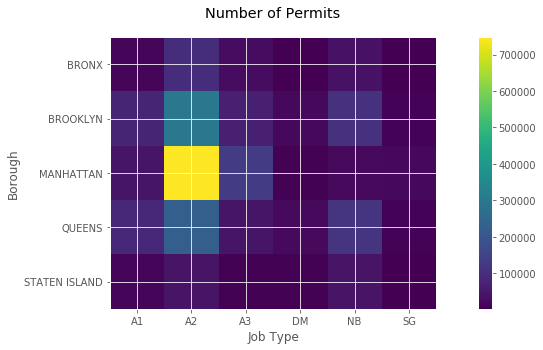

In [28]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
cax = ax.matshow(tot_borough_jtype)
fig.colorbar(cax)
ax.set_xticklabels([' ']+tot_borough_jtype.columns.tolist())
ax.set_yticklabels([' ']+tot_borough_jtype.index.tolist())
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Job Type')
ax.set_ylabel('Borough')
plt.title('Number of Permits')

In [29]:
chi_sq_statistic, p_val, _, _ = chi2_contingency(tot_borough_jtype)
print ('chi_sq_statistic = {}, p_val = {}'.format(chi_sq_statistic, p_val))

chi_sq_statistic = 361849.3352018677, p_val = 0.0


Text(0, 0.5, 'Number of Permits')

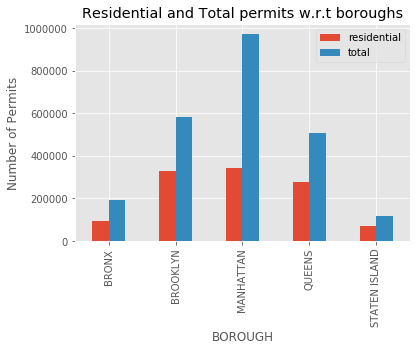

In [30]:
resid_tot_borough = pd.concat([resid_borough, tot_borough], axis = 1)
resid_tot_borough.columns = ['residential', 'total']
resid_tot_borough.plot(kind='bar', style='stacked')
plt.title('Residential and Total permits w.r.t boroughs')
plt.ylabel('Number of Permits')

1-block-away: 1113-1130, 1195-1209, 1823-1846, 1826, 1820, 1594, 1491-1507, 1602-1616, 1374-1393, 1294, 1030, 1011, 1274, 1049, 1028, 1009, 1272, 1029, 1010, 1273 <br>
2-blocks-away: 1068, 1131-1150, 1210-1226, 1851-1852, 1855, 1859-1864, 1624-1639, 1508-1524, 1312-1413, 1828-1829, 1822-1823, 1596, 1827, 1821, 1595 <br>
3-blocks-away: 1151-1170, 1227-1243, 1868-1881, 1847, 1332, 1414-1433, 1525-1541, 1646-1662 

#### How does Central Park (CP) impact the number of permits? How does the trend over years look?

In [31]:
# Creating list of blocks around central park
one_block_away = [np.arange(1113,1131), np.arange(1195,1210), np.arange(1823,1847), 
                  np.array([1826,1820,1594,1294, 1030, 1011, 1274, 1049, 1028, 1009, 1272, 1029, 1010, 1273]),
                  np.arange(1491,1508), np.arange(1602, 1617), np.arange(1374,1394)]
one_block_away = np.concatenate(one_block_away).tolist()
two_block_away = [np.arange(1131,1151), np.arange(1210,1227), np.arange(1859,1865), np.arange(1624,1640), np.arange(1508,1525),
                 np.arange(1312,1414), np.array([1068, 1851,1852,1855,1828,1829,1822,1823,1596,1827,1821,1595])]
two_block_away = np.concatenate(two_block_away).tolist()
three_block_away = [np.arange(1151,1170), np.arange(1227,1244), np.arange(1868,1882), np.arange(1414,1434), np.arange(1525,1542),
                np.arange(1646,1662), np.array([1847,1332])]
three_block_away = np.concatenate(three_block_away).tolist()

In [33]:
total_blocks = np.concatenate([one_block_away, two_block_away, three_block_away]).tolist()

In [34]:
# data consisting of blocks around central park in Manhattan
data_cp = data.loc[(data['Block'].isin(total_blocks))&(data['BOROUGH'] == 'MANHATTAN'),:]

In [35]:
pd.options.mode.chained_assignment = None

In [36]:
# Creating variable describing year when permit was issued
data_cp.loc[:,'issue_year'] = data_cp['Issuance Date'].dt.year.values

In [37]:
# mapping the distance from central park
data_cp['dis_cp'] = data_cp['Block'].apply(map_dis)

Text(0.5, 1.0, 'Number of Block vs distance from Central Park')

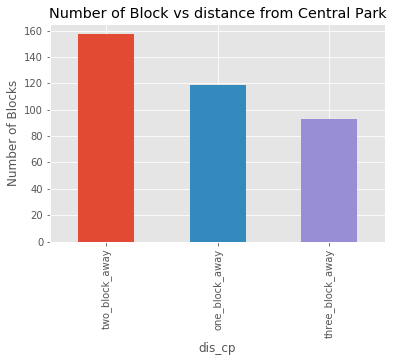

In [38]:
blocks_cp = data_cp[['Block','dis_cp']].drop_duplicates()['dis_cp'].value_counts()
blocks_cp.plot(kind = 'bar')
plt.xlabel('dis_cp')
plt.ylabel('Number of Blocks')
plt.title('Number of Block vs distance from Central Park')

Text(0.5, 1.0, 'Trend of permits over years w.r.t distance from CP')

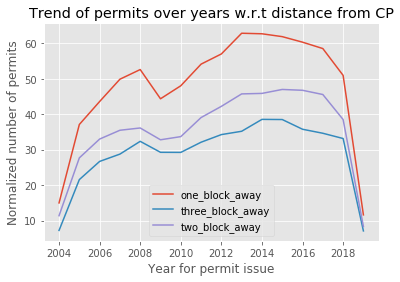

In [39]:
permits_year_dis = data_cp.groupby(['issue_year','dis_cp']).size().rename('#_permits').reset_index()
(permits_year_dis.pivot(index = 'issue_year', values='#_permits',columns='dis_cp')/blocks_cp).plot()
plt.xlabel('Year for permit issue')
plt.ylabel('Normalized number of permits')
plt.title('Trend of permits over years w.r.t distance from CP')

In [40]:
# data with block around central park with permits for only residential sites
data_cp_resid = data_cp.loc[data_cp['Residential'] == 'YES',:]

In [41]:
with open(r'F:\Old_Desktop\UC Davis\NYC permit data\data_cp.pkl', 'wb') as file:
    pickle.dump(data_cp, file, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
# with open(r'F:\Old_Desktop\UC Davis\NYC permit data\data_cp.pkl', 'rb') as file:
#     data_cp = pickle.load(file)

Text(0.5, 1.0, 'Residential permits over years')

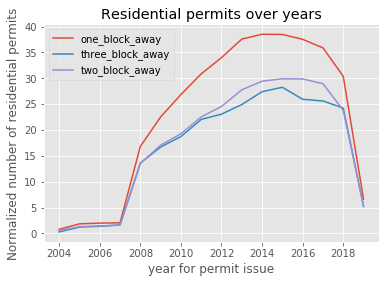

In [43]:
permits_year_dis_resid = data_cp_resid.groupby(['issue_year','dis_cp']).size().rename('#_permits').reset_index()
(permits_year_dis_resid.pivot(index = 'issue_year', values='#_permits',columns='dis_cp')/blocks_cp).plot()
plt.xlabel('year for permit issue')
plt.ylabel('Normalized number of residential permits')
plt.title('Residential permits over years')

### Permits in Manhattan

In [44]:
data_man = data.loc[(data['BOROUGH'] == 'MANHATTAN'),:]

In [45]:
# deleting data as no use further
del data, data_cp, data_cp_resid

In [46]:
# Creating issue year variable, removing blocks with null values, converting block and lot type to int
data_man.loc[:,'issue_year'] = data_man['Issuance Date'].dt.year.values.copy()
data_man = data_man.loc[~data_man['Block'].isnull(),:]
data_man[['Block','Lot']] = data_man[['Block','Lot']].apply(lambda x: x.astype('int'))

### Relationship between distance from park, permit lags, and other variables on sales value 

In [48]:
# Importing rolling sales data
sales = pd.read_excel('F:/Old_Desktop/UC Davis/NYC permit data/rollingsales_manhattan.xls', skiprows=3, header = 1)

In [49]:
sales.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [50]:
# Date time type
sales['SALE DATE'] = pd.to_datetime(sales['SALE DATE'], format='%Y-%m-%d')

In [51]:
# binning the year build variable
sales['YEAR BUILT'] = pd.cut(sales['YEAR BUILT'], bins = [sales['YEAR BUILT'].min(), 1800, 1850, 1900, 1950, 2000, 
                                                          sales['YEAR BUILT'].max()])

In [52]:
# Dropping unimportant variables
sales.drop(['BOROUGH','NEIGHBORHOOD','EASE-MENT','ADDRESS','APARTMENT NUMBER','TOTAL UNITS', 'TAX CLASS AT TIME OF SALE',
           'BUILDING CLASS AT PRESENT', 'SALE DATE', 'LAND SQUARE FEET'], axis = 1, inplace = True)

In [53]:
# max sales for building sold more than once
max_sales = sales.groupby(['BLOCK', 'LOT'])['SALE PRICE'].max().rename('max_sales').reset_index()

In [54]:
sales = sales.merge(max_sales, on = ['BLOCK', 'LOT']).drop('SALE PRICE', axis = 1)
sales.rename(mapper = {'BLOCK': 'Block', 'LOT': 'Lot'}, axis = 1, inplace = True)
sales.drop_duplicates(inplace = True)

In [56]:
# Blocks in manhattan that not in sales data
blocks_notin_sales = set(data_man['Block']) - set(sales['Block']) 
len(blocks_notin_sales)

556

In [58]:
with open(r'F:\Old_Desktop\UC Davis\NYC permit data\sales.pkl', 'wb') as file:
    pickle.dump(sales, file, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
# with open(r'F:\Old_Desktop\UC Davis\NYC permit data\sales.pkl', 'rb') as file:
#     sales = pickle.load(file)

In [60]:
# merging sales data with permit data
sales_data_man = data_man.merge(sales, on = ['Block', 'Lot'], how = 'inner')

In [62]:
sales_data_man[['Block','Lot']].drop_duplicates().shape

(3160, 2)

In [63]:
# binning issue year variable 
sales_data_man['issue_year'] = pd.cut(sales_data_man['issue_year'], bins=[2003,2008,2012,2016,2019], 
                                     labels = ['2004-2008', '2009-2012', '2013-2016', '2017-2019'])

### Create number of permits for past years grouped by 1) block and lot 2) Census Tract 3) Zip Code

In [64]:
permits_bl = pd.pivot_table(sales_data_man, index = ['Block', 'Lot'], columns='issue_year', aggfunc='count', values='max_sales', 
               fill_value=0)

In [65]:
permits_bl.columns = permits_bl.columns.astype('str')
permits_bl.reset_index(inplace=True)
permits_bl.head()

issue_year,Block,Lot,2004-2008,2009-2012,2013-2016,2017-2019
0,2,2,0,1,22,3
1,8,39,8,32,11,1
2,11,14,15,17,18,0
3,11,17,0,6,3,4
4,13,1,8,14,32,8


In [75]:
block_lot_man = sales_data_man[['Block', 'Lot', 'CENSUS_TRACT']].drop_duplicates()

In [76]:
permits_bl = permits_bl.merge(block_lot_man, on = ['Block', 'Lot'])

In [78]:
permits_ct = pd.pivot_table(sales_data_man, index = ['CENSUS_TRACT'], columns='issue_year', aggfunc='count', values='max_sales', 
               fill_value=0)

In [79]:
permits_ct.columns = permits_ct.columns.astype('str')
permits_ct.reset_index(inplace=True)
permits_ct.tail()

issue_year,CENSUS_TRACT,2004-2008,2009-2012,2013-2016,2017-2019
247,22302.0,6,4,4,4
248,23501.0,24,20,16,13
249,23502.0,10,2,18,3
250,23801.0,0,6,37,13
251,24301.0,13,8,9,9


In [80]:
permits_zc = pd.pivot_table(sales_data_man, index = ['Zip Code'], columns='issue_year', aggfunc='count', values='max_sales', 
               fill_value=0)

In [81]:
permits_zc.columns = permits_zc.columns.astype('str')
permits_zc.columns = ['2004-2008_#_permits_zc', '2009-2012_#_permits_zc', '2013-2016_#_permits_zc', '2017-2019_#_permits_zc']
permits_zc.reset_index(inplace=True)
permits_zc.tail()

,Zip Code,2004-2008_#_permits_zc,2009-2012_#_permits_zc,2013-2016_#_permits_zc,2017-2019_#_permits_zc
39,10069.0,3,20,25,17
40,10075.0,1517,1187,1772,800
41,10105.0,7,10,7,10
42,10128.0,2311,2258,2742,1357
43,10463.0,0,0,0,2


In [82]:
block_lot_zc = sales_data_man[['Block', 'Lot', 'Zip Code']].drop_duplicates()

In [83]:
permits_zc = permits_zc.merge(block_lot_zc, on = ['Zip Code'])

In [85]:
permits_lag = permits_bl.merge(permits_ct, on = ['CENSUS_TRACT'], suffixes=['_#_permits_bl','_#_permits_ct'])

In [86]:
permits_lag = permits_lag.merge(permits_zc, on = ['Block', 'Lot'], suffixes=['','_#_permits_zc'])

In [87]:
permits_lag.shape

(3168, 16)

In [90]:
permits_lag.drop(['Block', 'Lot'], axis = 1).corr()

,2004-2008_#_permits_bl,2009-2012_#_permits_bl,2013-2016_#_permits_bl,2017-2019_#_permits_bl,CENSUS_TRACT,2004-2008_#_permits_ct,2009-2012_#_permits_ct,2013-2016_#_permits_ct,2017-2019_#_permits_ct,Zip Code,2004-2008_#_permits_zc,2009-2012_#_permits_zc,2013-2016_#_permits_zc,2017-2019_#_permits_zc
2004-2008_#_permits_bl,1.000000,0.810840,0.761430,0.660222,0.039812,0.328692,0.317638,0.322717,0.306686,0.045762,0.246076,0.239579,0.246551,0.228658
2009-2012_#_permits_bl,0.810840,1.000000,0.788749,0.689594,0.033198,0.297849,0.318670,0.307400,0.291485,0.031459,0.219147,0.223926,0.226488,0.212573
2013-2016_#_permits_bl,0.761430,0.788749,1.000000,0.805374,0.038118,0.269567,0.274214,0.302339,0.281784,0.024276,0.208715,0.209271,0.221899,0.205197
2017-2019_#_permits_bl,0.660222,0.689594,0.805374,1.000000,0.012511,0.227432,0.231439,0.252892,0.268810,0.013673,0.175447,0.178630,0.187416,0.179248
CENSUS_TRACT,0.039812,0.033198,0.038118,0.012511,1.000000,0.017338,0.040622,0.031297,-0.016346,0.422313,0.083180,0.082632,0.068588,0.034745
2004-2008_#_permits_ct,0.328692,0.297849,0.269567,0.227432,0.017338,1.000000,0.973691,0.968230,0.943920,0.190939,0.666972,0.650617,0.655791,0.622632
2009-2012_#_permits_ct,0.317638,0.318670,0.274214,0.231439,0.040622,0.973691,1.000000,0.966712,0.937143,0.187772,0.648648,0.647845,0.646519,0.617830
2013-2016_#_permits_ct,0.322717,0.307400,0.302339,0.252892,0.031297,0.968230,0.966712,1.000000,0.965536,0.189766,0.670995,0.662315,0.677329,0.641908
2017-2019_#_permits_ct,0.306686,0.291485,0.281784,0.268810,-0.016346,0.943920,0.937143,0.965536,1.000000,0.159006,0.670279,0.666250,0.676173,0.654605
Zip Code,0.045762,0.031459,0.024276,0.013673,0.422313,0.190939,0.187772,0.189766,0.159006,1.000000,0.176411,0.160150,0.151639,0.117620


In [91]:
permits_lag.drop(['2004-2008_#_permits_ct', '2009-2012_#_permits_ct',
                 '2004-2008_#_permits_zc', '2009-2012_#_permits_zc'], axis = 1, inplace = True)

In [92]:
permits_lag.tail()

,Block,Lot,2004-2008_#_permits_bl,2009-2012_#_permits_bl,2013-2016_#_permits_bl,2017-2019_#_permits_bl,CENSUS_TRACT,2013-2016_#_permits_ct,2017-2019_#_permits_ct,Zip Code,2013-2016_#_permits_zc,2017-2019_#_permits_zc
3163,2250,54,6,2,0,9,307.0,51,37,10034.0,132,101
3164,2250,72,0,0,1,3,307.0,51,37,10034.0,132,101
3165,2243,347,5,6,3,6,303.0,3,11,10034.0,132,101
3166,2243,354,3,0,0,0,303.0,3,11,10034.0,132,101
3167,2250,14,5,2,0,5,303.0,3,11,10034.0,132,101


In [93]:
del permits_bl, permits_ct, permits_zc

### number of each job types grouped by block and lot

In [94]:
jt_bl = pd.pivot_table(sales_data_man, index = ['Block', 'Lot'], columns = ['Job Type'], values = 'max_sales', 
               aggfunc='count', fill_value=0).reset_index()

In [95]:
jt_bl.head()

Job Type,Block,Lot,A1,A2,A3,DM,NB,SG
0,2,2,0,10,16,0,0,0
1,8,39,18,17,14,0,0,3
2,11,14,5,40,5,0,0,0
3,11,17,0,10,3,0,0,0
4,13,1,1,53,6,0,0,2


In [96]:
jt_bl.shape

(3160, 8)

### number of self_cert grouped by block and lot

In [97]:
sc_bl = pd.pivot_table(sales_data_man, index = ['Block', 'Lot'], columns = ['Self_Cert'], values = 'max_sales',
                      aggfunc = 'count', fill_value = 0)
sc_bl.columns = ['sc_N', 'sc_Y']
sc_bl.reset_index(inplace = True)

In [98]:
sc_bl.shape

(3083, 4)

In [99]:
sc_bl.head()

,Block,Lot,sc_N,sc_Y
0,2,2,6,20
1,8,39,15,14
2,11,14,26,10
3,11,17,3,10
4,13,1,22,38


### number of residential permits

In [100]:
resid_bl = sales_data_man.groupby(['Block', 'Lot'])['Residential'].count().reset_index()

In [101]:
resid_bl.head()

,Block,Lot,Residential
0,2,2,0
1,8,39,15
2,11,14,30
3,11,17,0
4,13,1,0


In [102]:
resid_bl.shape

(3160, 3)

### number of non-profit permits

In [103]:
sales_data_man['Non-Profit'].unique()

array(['N', 'Y', nan], dtype=object)

In [104]:
np_bl = pd.pivot_table(sales_data_man, index = ['Block', 'Lot'], columns = ['Non-Profit'], values = 'max_sales',
                      aggfunc = 'count', fill_value = 0)
np_bl.columns = ['np_N', 'np_Y']
np_bl.reset_index(inplace = True)

In [105]:
np_bl.head()

,Block,Lot,np_N,np_Y
0,2,2,24,2
1,8,39,52,0
2,11,14,50,0
3,11,17,13,0
4,13,1,50,4


In [106]:
np_bl.shape

(3160, 4)

### Data of council district, dis_cp as per block and lot

In [107]:
cd_dis_cp_bl = sales_data_man[['Block', 'Lot', 'COUNCIL_DISTRICT']].drop_duplicates()

In [108]:
cd_dis_cp_bl.shape

(3168, 3)

In [109]:
# Merge all the permit data
permit_data = permits_lag.merge(jt_bl, on = ['Block', 'Lot'])
permit_data = permit_data.merge(sc_bl, on = ['Block', 'Lot'])
permit_data = permit_data.merge(resid_bl, on = ['Block', 'Lot'])
permit_data = permit_data.merge(np_bl, on = ['Block', 'Lot'])
permit_data = permit_data.merge(cd_dis_cp_bl, on = ['Block', 'Lot'])

In [110]:
with open(r'F:\Old_Desktop\UC Davis\NYC permit data\permit_data.pkl', 'wb') as file:
    pickle.dump(permit_data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
# with open(r'F:\Old_Desktop\UC Davis\NYC permit data\permit_data.pkl', 'rb') as file:
#     permit_data = pickle.load(file)

In [112]:
permit_data.shape

(3101, 24)

### Add distances from tube stations

In [113]:
sub_loc = pd.read_csv(r'F:\Old_Desktop\UC Davis\NYC permit data\NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

In [114]:
sub_loc.shape

(1868, 32)

In [115]:
sub_loc.columns

Index(['Division', 'Line', 'Station Name', 'Station Latitude',
       'Station Longitude', 'Route1', 'Route2', 'Route3', 'Route4', 'Route5',
       'Route6', 'Route7', 'Route8', 'Route9', 'Route10', 'Route11',
       'Entrance Type', 'Entry', 'Exit Only', 'Vending', 'Staffing',
       'Staff Hours', 'ADA', 'ADA Notes', 'Free Crossover',
       'North South Street', 'East West Street', 'Corner', 'Entrance Latitude',
       'Entrance Longitude', 'Station Location', 'Entrance Location'],
      dtype='object')

In [117]:
# Tuples of (Lat, Lon) for stations
sub_cord = sub_loc[['Station Latitude', 'Station Longitude']].drop_duplicates()
sub_cord = [tuple(x) for x in sub_cord.values]

In [118]:
# Tuples of (Lat, Lon) for blocks and lot combination
bl_cord = [tuple(x) for x in 
           sales_data_man.groupby(['Block','Lot'])[['LATITUDE', 'LONGITUDE']].first().drop_duplicates().values]

In [119]:
near_st = [calc_dis(x,key=0.3) for x in bl_cord]

In [120]:
# Creating the data with stations within 300 feet for a block and lot combination
bl_cord_df = sales_data_man.groupby(['Block','Lot'])[['LATITUDE', 'LONGITUDE']].first().drop_duplicates().reset_index()
bl_cord_df['near_st'] = near_st

In [121]:
with open(r'F:\Old_Desktop\UC Davis\NYC permit data\bl_cord_df.pkl', 'wb') as file:
    pickle.dump(bl_cord_df, file, protocol=pickle.HIGHEST_PROTOCOL)

In [122]:
# with open(r'F:\Old_Desktop\UC Davis\NYC permit data\bl_cord_df.pkl', 'rb') as file:
#     bl_cord_df = pickle.load(file)

In [123]:
# Create the data set containing permit, sales and distance data
full_data_st = permit_data.merge(sales, on = ['Block', 'Lot'])
full_data_st = full_data_st.merge(bl_cord_df, on = ['Block', 'Lot'])
full_data_st = full_data_st.query('max_sales>0')

In [124]:
full_data_st.drop(['Block', 'Lot', 'ZIP CODE', 'Zip Code', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BUILDING CLASS CATEGORY',
               'BUILDING CLASS AT TIME OF SALE', 'LATITUDE', 'LONGITUDE'], #, 
               axis = 1, inplace = True)

In [125]:
full_data_st.columns

Index(['2004-2008_#_permits_bl', '2009-2012_#_permits_bl',
       '2013-2016_#_permits_bl', '2017-2019_#_permits_bl',
       '2013-2016_#_permits_ct', '2017-2019_#_permits_ct',
       '2013-2016_#_permits_zc', '2017-2019_#_permits_zc', 'A1', 'A2', 'A3',
       'DM', 'NB', 'SG', 'sc_N', 'sc_Y', 'Residential', 'np_N', 'np_Y',
       'TAX CLASS AT PRESENT', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'max_sales', 'near_st'],
      dtype='object')

In [126]:
full_data_st.dropna(inplace = True)
full_data_st.shape

(2518, 26)

In [127]:
full_data_st[['TAX CLASS AT PRESENT']] = full_data_st['TAX CLASS AT PRESENT'].astype('str')
cat_cols = ['YEAR BUILT', 'TAX CLASS AT PRESENT']

In [128]:
# Lable Encoding for categorical variables
le = LabelEncoder()
full_data_st[cat_cols] = full_data_st[cat_cols].apply(lambda x: le.fit_transform(x))

In [129]:
X_ps = full_data_st.drop('max_sales', axis = 1)
y_ps = np.log(full_data_st['max_sales'].values)

In [130]:
# Splitting in train and test/validation set
X_ps_train, X_ps_test, y_ps_train, y_ps_test = train_test_split(X_ps, y_ps, test_size = 0.2, random_state = 44)

In [131]:
# One hot encoder
oh_enc = OneHotEncoder(categories='auto')
ct = ColumnTransformer(
    [('oh_enc', OneHotEncoder(sparse=False), cat_cols),]
)
X_ps_train_cat = ct.fit_transform(X_ps_train)
X_ps_test_cat = ct.transform(X_ps_test)

F:\Python\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [132]:
X_ps_train_enc = np.concatenate([X_ps_train.drop(cat_cols, axis=1).values, X_ps_train_cat], axis=1)
X_ps_test_enc = np.concatenate([X_ps_test.drop(cat_cols, axis=1).values, X_ps_test_cat], axis=1)

In [133]:
feat = X_ps_train.drop(cat_cols, axis=1).columns.tolist()
feat.extend(ct.get_feature_names())

#### XGBOOST with Hyperopt

In [134]:
# Parameter space considered for hyper-parameter tuning
params_space = {
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.7, 1, 0.05),
    'gamma': hp.quniform('gamma', 0, 1, 0.05),
    'depth': hp.choice('depth',np.arange(1,16, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1,15,2),
    'eval_metric': 'rmse',
    'objective': 'reg:linear'
}

In [135]:
# write the ouptut to file
out_file = r'F:\Old_Desktop\UC Davis\NYC permit data\xgboost_trials_nyc.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['iteration', 'loss', 'params', 'train_time', 'n_trees'])
of_connection.close()

In [175]:
# Run optimization
trials = hyperopt.Trials()
global  ITERATION
ITERATION = 0
best = hyperopt.fmin(
    objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=800,
    trials=trials,
    rstate=np.random.RandomState(ITERATION)
)

ITERATION: 50
params:  {'colsample_bytree': 1.0, 'depth': 5, 'eval_metric': 'rmse', 'gamma': 0.9500000000000001, 'min_child_weight': 10.0, 'objective': 'reg:linear', 'subsample': 0.55}
loss: 1.31133
ITERATION: 100
params:  {'colsample_bytree': 0.7000000000000001, 'depth': 6, 'eval_metric': 'rmse', 'gamma': 0.8, 'min_child_weight': 14.0, 'objective': 'reg:linear', 'subsample': 0.8500000000000001}
loss: 1.28672
ITERATION: 150
params:  {'colsample_bytree': 0.9500000000000001, 'depth': 4, 'eval_metric': 'rmse', 'gamma': 0.9, 'min_child_weight': 12.0, 'objective': 'reg:linear', 'subsample': 0.65}
loss: 1.27413
ITERATION: 200
params:  {'colsample_bytree': 0.9500000000000001, 'depth': 14, 'eval_metric': 'rmse', 'gamma': 0.35000000000000003, 'min_child_weight': 6.0, 'objective': 'reg:linear', 'subsample': 0.8500000000000001}
loss: 1.31516
ITERATION: 250
params:  {'colsample_bytree': 0.8500000000000001, 'depth': 3, 'eval_metric': 'rmse', 'gamma': 1.0, 'min_child_weight': 14.0, 'objective': 'reg

In [177]:
# Best parameters
xgb_tune_results = pd.read_csv(out_file)
xgb_tune_results.sort_values('loss', ascending=True, inplace=True)
xgb_tune_results.reset_index(inplace = True)
best_params = ast.literal_eval(xgb_tune_results.loc[0, 'params'])
best_params

{'colsample_bytree': 0.8,
 'depth': 5,
 'eval_metric': 'rmse',
 'gamma': 0.15000000000000002,
 'min_child_weight': 14.0,
 'objective': 'reg:linear',
 'subsample': 0.9500000000000001}

In [237]:
# training the model with best parameters to find optimum value of estimators
xgbmodel = XGBRegressor(learning_rate=0.05, n_estimators=3000, n_jobs = -1, eval_metric = 'rmse', seed = 44, 
                        min_child_weight = 14, gamma = 0.15, subsample = 0.95, colsample_bytree=.8, max_depth = 5)
xgtrain = xgb.DMatrix(X_ps_train_enc, label=y_ps_train)
xgval = xgb.DMatrix(X_ps_test_enc, label = y_ps_test)
xgb_params = xgbmodel.get_xgb_params()
watchlist = [(xgtrain, 'train'), (xgval, 'val')]
xgbresults = xgb.train(xgb_params, xgtrain, num_boost_round = 1000, evals = watchlist,
                          early_stopping_rounds = 100, verbose_eval = 100)

[0]	train-rmse:13.4574	val-rmse:13.3604
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.10896	val-rmse:1.26085
[200]	train-rmse:0.95366	val-rmse:1.26541
Stopping. Best iteration:
[106]	train-rmse:1.09926	val-rmse:1.2588



Text(0.5, 1.0, 'Performance of model on validation set')

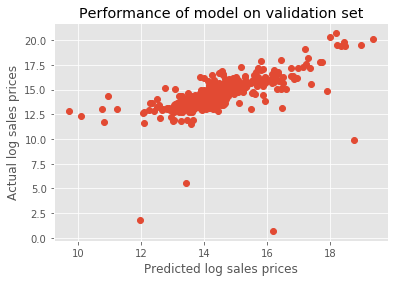

In [238]:
plt.plot(xgbresults.predict(xgb.DMatrix(X_ps_test_enc)), y_ps_test, 'o')
plt.xlabel('Predicted log sales prices')
plt.ylabel('Actual log sales prices')
plt.title('Performance of model on validation set')

In [278]:
# Finally training on full data with required number of estimators
xgbmodel_full = XGBRegressor(learning_rate=0.05, n_estimators=106, n_jobs = -1, eval_metric = 'rmse', seed = 44, 
                        min_child_weight = 14, gamma = 0.15, subsample = 0.95, colsample_bytree=.8, max_depth = 5)
xgb_params = xgbmodel.get_xgb_params()
xgbresults_final = xgbmodel_full.fit(np.concatenate([X_ps_train_enc, X_ps_test_enc]), np.concatenate([y_ps_train, y_ps_test]))

Text(0.5, 1.0, '10 most important features for sales price')

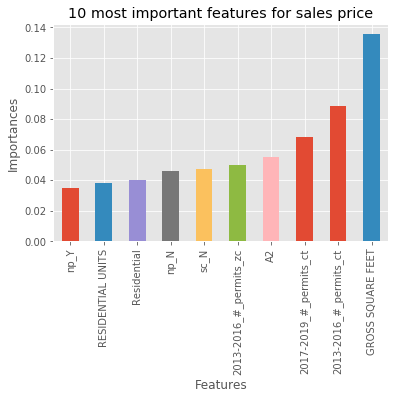

In [282]:
pd.Series(data = xgbresults_final.feature_importances_, index=feat).sort_values()[-10:].plot('bar')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.title('10 most important features for sales price')